# Projet de préduction de précipitations pour la région de Taroudant au Maroc - Groupe 1
## Réalisé par : MESKINE FATIMA EZZAHRA, BABADAIH Najlae, Ait Ben M'bark Ikram
### Veuillez trouvez notre dataset dans le meme répértoire sous nom: "taroudant_nwp_2000_2025.csv"
## Code source du modèle LSTM

2025-12-16 21:55:25.793504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - loss: 2.5003e-04 - mae: 0.0048 - val_loss: 1.1149e-04 - val_mae: 0.0020
Epoch 2/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 7.4708e-05 - mae: 0.0025 - val_loss: 8.6866e-05 - val_mae: 0.0020
Epoch 3/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 5.5746e-05 - mae: 0.0021 - val_loss: 8.7411e-05 - val_mae: 0.0016
Epoch 4/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 5.0658e-05 - mae: 0.0019 - val_loss: 8.4414e-05 - val_mae: 0.0023
Epoch 5/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 4.8375e-05 - mae: 0.0019 - val_loss: 8.4613e-05 - val_mae: 0.0020
Epoch 6/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 4.6883e-05 - mae: 0.0019 - val_loss: 8.2393e-05 - val_mae: 0.0013
Epoch 7/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 4.5990e-05 - mae: 0.0018 - val_loss: 8.3983e-05 - val_mae: 0.0013
Epoch 8/50
4802/4802 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 4.5577e-05 - mae: 0.0018 -

MAE : 0.0254 mm
RMSE : 0.2110 mm
R2 : 0.2937
✅ Tout est sauvegardé : modèle, scaler, prédictions, résultats globaux et par intensité


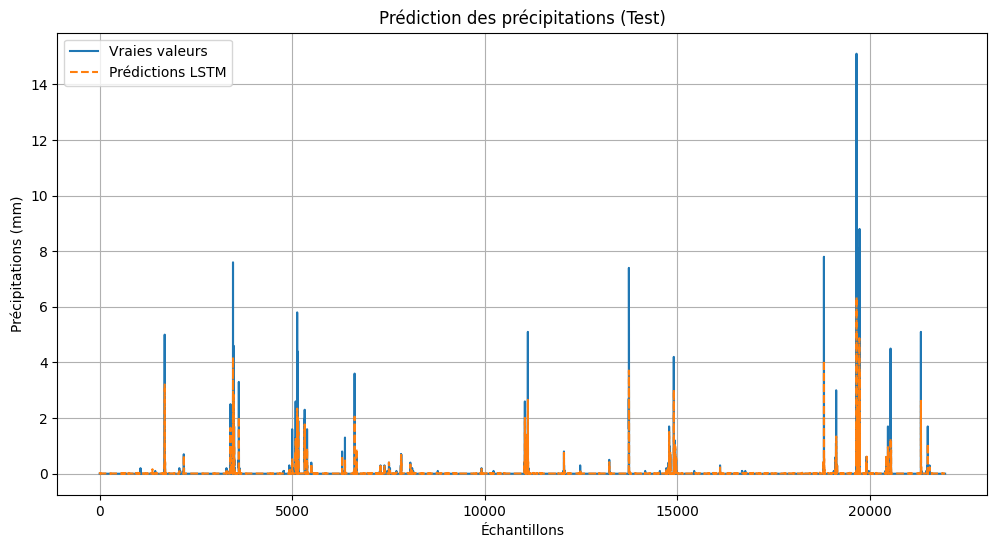

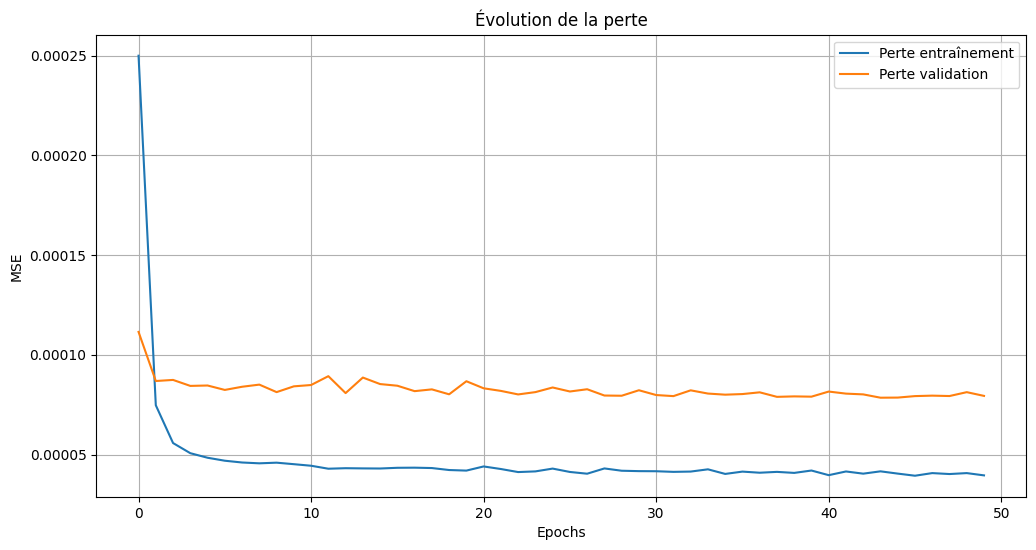

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

#Chargement et prétraitement
df = pd.read_csv('taroudant_nwp_2000_2025.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df.replace(-999, np.nan, inplace=True)
df.interpolate(method='linear', inplace=True)
df.dropna(inplace=True)

# Création des lags
for lag in range(1, 8):
    df[f'precip_mm_lag_{lag}'] = df['precip_mm'].shift(lag)

df['precip_mm_rolling_mean_7'] = df['precip_mm'].rolling(window=7).mean()
df['hour'] = df.index.hour
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

df.dropna(inplace=True)
features = df.columns.tolist()

#Normalisation
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=features, index=df.index)
joblib.dump(scaler, 'scaler.pkl')

#Création des séquences
def create_sequences(data, target_col, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)
        y.append(data.iloc[i + lookback][target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target_col='precip_mm', lookback=24)

#Split train/val/test
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

#Modèle LSTM
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

#Prédictions et dé-normalisation
y_pred_scaled = model.predict(X_test)

target_index = features.index('precip_mm')

dummy_pred = np.zeros((len(y_pred_scaled), len(features)))
dummy_pred[:, target_index] = y_pred_scaled[:, 0]
y_pred = scaler.inverse_transform(dummy_pred)[:, target_index]

dummy_test = np.zeros((len(y_test), len(features)))
dummy_test[:, target_index] = y_test
y_test_actual = scaler.inverse_transform(dummy_test)[:, target_index]

#Métriques globales
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print(f"MAE : {mae:.4f} mm")
print(f"RMSE : {rmse:.4f} mm")
print(f"R2 : {r2:.4f}")

#Sauvegarde du modèle et fichiers
model.save('lstm_model.h5')
joblib.dump(scaler, 'scaler.pkl')

predictions_df = pd.DataFrame({
    'date': df.index[train_size + val_size+24:],
    'true': y_test_actual,
    'pred': y_pred,
    'error': y_pred - y_test_actual,
    'abs_error': np.abs(y_pred - y_test_actual)
})
predictions_df.to_csv('lstm_predictions.csv', index=False)

results_df = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'R2'],
    'value': [mae, rmse, r2]
})
results_df.to_csv('lstm_results.csv', index=False)

#Métriques par intensité
intensity_categories = {
    'zeros': (0, 0),
    'very_light': (0, 0.1),
    'light': (0.1, 1.0),
    'moderate': (1.0, 5.0),
    'heavy': (5.0, np.inf)
}

by_intensity = {}
for cat, (low, high) in intensity_categories.items():
    if cat == 'zeros':
        mask = y_test_actual == 0
    elif high == np.inf:
        mask = y_test_actual > low
    else:
        mask = (y_test_actual > low) & (y_test_actual <= high)
    
    if mask.sum() > 0:
        by_intensity[cat] = {
            'mae': mean_absolute_error(y_test_actual[mask], y_pred[mask]),
            'rmse': np.sqrt(mean_squared_error(y_test_actual[mask], y_pred[mask])),
            'count': mask.sum()
        }

intensity_df = pd.DataFrame.from_dict(by_intensity, orient='index')
intensity_df.to_csv('lstm_results_by_intensity.csv')

print("✅ Tout est sauvegardé : modèle, scaler, prédictions, résultats globaux et par intensité")

#Visualisations
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Vraies valeurs')
plt.plot(y_pred, label='Prédictions LSTM', linestyle='--')
plt.title('Prédiction des précipitations (Test)')
plt.xlabel('Échantillons')
plt.ylabel('Précipitations (mm)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Évolution de la perte')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()
